In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

from gensim import matutils, models
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import scipy.sparse

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Loading data

In [2]:
df=pd.read_csv("./data/clean_df_eng.csv")
df.head()

,cord_uid,source_x,title,doi,abstract,publish_time,authors,journal,url,publish_year,lang
0,gl6kg2gt,WHO,Progress Toward Poliovirus Containment Impleme...,NaN,"Since 1988, when World Health Organization (WH...",2020-01-01,"Moffett, Daphne B; Llewellyn, Anna; Singh, Har...",MMWR Morb Mortal Wkly Rep,NaN,2020,en
1,jjgqnzp6,WHO,Anti)social Monitoring: Law and (or) Expediency?,NaN,The paper is focused on analysis of compliance...,2020-01-01,"Savelyev, Alexander I.",Zakon,NaN,2020,en
2,s5hd55ch,WHO,Running of high patient volume radiation oncol...,NaN,"Purpose: Due to COVID 19 pandemic, the treatme...",2020-01-01,"Gupta, Manoj; Ahuja, Rachit; Gupta, Sweety; Jo...",Radiat. Oncol. J.,NaN,2020,en
3,zl9kf1ax,MedRxiv; WHO,Rapid Development of a De Novo Convalescent Pl...,10.1101/2020.10.23.20217901,BackgroundWith no vaccine or treatment for SAR...,2020-01-01,"Reik, Rita; Gammon, Richard; Carol, Nancy; Smi...",NaN,http://medrxiv.org/cgi/content/short/2020.10.2...,2020,en
4,gzjfyitd,WHO,COVID – 19 and gravid mothers,NaN,Human history is observing a very horrible and...,2020-01-01,"Sadavarte, S.; Chaudhari, B. V.",International Journal of Research in Pharmaceu...,NaN,2020,en


In [3]:
#sample only 100 papers first
# papers = df.sample(100)

#sample 1000 papers
# papers = df.sample(1000)

#try on full dataset
papers = df

# Data Pre-processing

In [4]:
## Remove punctuation/lower casing
# Load the regex library
import re

# Remove punctuation
papers['abstract_processed'] = papers['abstract'].map(lambda x: re.sub('[,/.!?:]', '',x))

# Convert to lowercase
papers['abstract_processed'] = papers['abstract_processed'].map(lambda x: x.lower())

# Save as csv for later
papers.to_csv("processed_clean_df.csv")
papers.head()

,cord_uid,source_x,title,doi,abstract,publish_time,authors,journal,url,publish_year,lang,abstract_processed
0,gl6kg2gt,WHO,Progress Toward Poliovirus Containment Impleme...,NaN,"Since 1988, when World Health Organization (WH...",2020-01-01,"Moffett, Daphne B; Llewellyn, Anna; Singh, Har...",MMWR Morb Mortal Wkly Rep,NaN,2020,en,since 1988 when world health organization (who...
1,jjgqnzp6,WHO,Anti)social Monitoring: Law and (or) Expediency?,NaN,The paper is focused on analysis of compliance...,2020-01-01,"Savelyev, Alexander I.",Zakon,NaN,2020,en,the paper is focused on analysis of compliance...
2,s5hd55ch,WHO,Running of high patient volume radiation oncol...,NaN,"Purpose: Due to COVID 19 pandemic, the treatme...",2020-01-01,"Gupta, Manoj; Ahuja, Rachit; Gupta, Sweety; Jo...",Radiat. Oncol. J.,NaN,2020,en,purpose due to covid 19 pandemic the treatment...
3,zl9kf1ax,MedRxiv; WHO,Rapid Development of a De Novo Convalescent Pl...,10.1101/2020.10.23.20217901,BackgroundWith no vaccine or treatment for SAR...,2020-01-01,"Reik, Rita; Gammon, Richard; Carol, Nancy; Smi...",NaN,http://medrxiv.org/cgi/content/short/2020.10.2...,2020,en,backgroundwith no vaccine or treatment for sar...
4,gzjfyitd,WHO,COVID – 19 and gravid mothers,NaN,Human history is observing a very horrible and...,2020-01-01,"Sadavarte, S.; Chaudhari, B. V.",International Journal of Research in Pharmaceu...,NaN,2020,en,human history is observing a very horrible and...


In [5]:
## Tokenize words and further clean-up text
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.abstract_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['since', 'when', 'world', 'health', 'organization', 'who', 'member', 'states', 'and', 'partners', 'launched', 'the', 'global', 'polio', 'eradication', 'initiative', 'the', 'number', 'of', 'wild', 'poliovirus', 'wpv', 'cases', 'has', 'declined', 'from', 'in', 'countries', 'to', 'in']


# Phrase Modeling: Bi-grams and Tri-grams

In [6]:
# Build the bigram and trigram models
bigram = models.Phrases(data_words, min_count=5, threshold=100)
# higher threshold fewer phrases
trigram = models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)

In [7]:
import spacy
import scispacy
import en_core_sci_lg

# Initialize spacy 'en_core_sci_lg' model, keeping only tagger component(for efficiency)
nlp = spacy.load("en_core_sci_lg", disable=['parser', 'ner'])
nlp.max_length = 3000000

In [8]:
#NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'ie', 'st', 'th', 'rd', 
                   'copyright', 'study', 'covid','covid-19', 'sars-cov-2', 
                   '2019-ncov', 'coronavirus','sars-cov','sars_cov'])


# Define functions for stopwords, bigram, trigrams, lemmatization
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) \
            if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc \
                          if token.pos_ in allowed_postags])
    return texts_out


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/crystalhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['world', 'health', 'organization', 'member', 'state', 'partner', 'launch', 'global', 'polio_eradication', 'initiative', 'number', 'wild_poliovirus', 'wpv', 'case', 'decline', 'country', 'country', 'global', 'commission', 'certification', 'poliomyelitis', 'eradication', 'gcc', 'declare', 'wpv', 'type', 'type', 'wpv', 'type', 'wpv', 'eradicate', 'globally', 'respectively', 'wild_poliovirus', 'type', 'wpv', 'remain', 'endemic', 'afghanistan', 'pakistan', 'containment', 'strict', 'biorisk', 'management', 'measure', 'vital', 'prevent', 'reintroduction', 'eradicate', 'poliovirus', 'community', 'poliovirus', 'facility', 'member', 'state', 'commit', 'contain', 'type', 'poliovirus', 'pv', 'poliovirus', 'essential', 'facility', 'pef', 'certify', 'accordance', 'global', 'standard', 'member', 'state', 'agree', 'report', 'national', 'pv', 'inventory', 'annually', 'destroy', 'unneede', 'pv', 'material', 'retain', 'material', 'establish', 'national', 'authority', 'containment', 'nacs', 'pef', 'audi

In [93]:
pickle.dump(data_words, open("data_words", "wb"))
pickle.dump(data_lemmatized, open("data_lemmatized", "wb"))

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Transformation: Corpus and Dictionary

In [10]:
import gensim.corpora as corpora

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# view check
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 4), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 2), (31, 1), (32, 2), (33, 1), (34, 2), (35, 1), (36, 4), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 3), (48, 1), (49, 4), (50, 1), (51, 2), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 3), (62, 1), (63, 1), (64, 5), (65, 1), (66, 1), (67, 1), (68, 1), (69, 3), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 4), (79, 1), (80, 1), (81, 5), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 7)]]


In [12]:
pickle.dump(id2word, open("id2word", "wb"))
pickle.dump(corpus, open("corpus", "wb"))

# Base Model

In [13]:
from gensim import matutils, models, utils
# Build LDA model
lda_model = models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=10,
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      per_word_topics=True)

In [14]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"student" + 0.016*"online" + 0.013*"education" + 0.013*"use" + '
  '0.011*"training" + 0.011*"learning" + 0.009*"medical" + 0.009*"school" + '
  '0.008*"program" + 0.007*"experience"'),
 (1,
  '0.023*"case" + 0.013*"number" + 0.012*"rate" + 0.012*"datum" + '
  '0.011*"country" + 0.010*"population" + 0.009*"death" + 0.009*"model" + '
  '0.008*"result" + 0.008*"measure"'),
 (2,
  '0.025*"cell" + 0.013*"protein" + 0.007*"response" + 0.007*"expression" + '
  '0.007*"target" + 0.006*"gene" + 0.006*"effect" + 0.006*"immune" + '
  '0.006*"drug" + 0.006*"show"'),
 (3,
  '0.082*"cov" + 0.079*"sar" + 0.028*"infection" + 0.021*"virus" + '
  '0.019*"respiratory" + 0.017*"test" + 0.016*"viral" + 0.012*"positive" + '
  '0.011*"syndrome" + 0.010*"severe"'),
 (4,
  '0.051*"patient" + 0.022*"care" + 0.013*"hospital" + 0.012*"treatment" + '
  '0.010*"use" + 0.008*"result" + 0.008*"clinical" + 0.007*"cancer" + '
  '0.007*"conclusion" + 0.007*"pandemic"'),
 (5,
  '0.020*"health" + 0.012*"use

In [56]:
# get most dominant topic of each document
corpus_topics = [sorted(topic, key=lambda x: x[1])[0] for topic in topics for topics in doc_lda]

corpus_topics[:10]

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(9, 0.016205344),
 (9, 0.016205344),
 (9, 0.016205344),
 (9, 0.016205344),
 (9, 0.016205344),
 (9, 0.016205344),
 (9, 0.016205344),
 (9, 0.016205344),
 (9, 0.016205344),
 (9, 0.016205344)]

In [84]:
# top 20 significant terms and their probabilities for each topic
topics=[]
for i in range(0,10):
    topic_list=[]
    for term, wt in lda_model.show_topic(i, topn=20):
        topic_list.append((term, round(wt,3)))
    topics.append(topic_list)

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-87-a213c9d69f06>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"student, online, education, use, training, learning, medical, school, program, experience, information, research, virtual, technology, practice, user, university, survey, medium, digital"
Topic2,"case, number, rate, datum, country, population, death, model, result, measure, increase, time, estimate, high, epidemic, period, lockdown, disease, spread, outbreak"
Topic3,"cell, protein, response, expression, target, gene, effect, immune, drug, show, human, activity, receptor, mechanism, host, potential, ace, use, role, induce"
Topic4,"cov, sar, infection, virus, respiratory, test, viral, positive, syndrome, severe, acute, sample, antibody, testing, result, assay, patient, disease, rna, detection"
Topic5,"patient, care, hospital, treatment, use, result, clinical, cancer, conclusion, pandemic, outcome, method, group, surgery, risk, include, trial, follow, medical, time"
Topic6,"health, use, participant, mental, result, high, child, pandemic, survey, risk, anxiety, report, level, factor, social, symptom, related, associate, measure, increase"
Topic7,"disease, review, study, treatment, pandemic, infection, clinical, health, vaccine, include, evidence, use, drug, article, search, cause, virus, research, current, literature"
Topic8,"patient, disease, severe, clinical, high, group, mortality, risk, case, associate, outcome, result, age, include, day, conclusion, symptom, increase, acute, analysis"
Topic9,"health, pandemic, public, social, system, impact, research, need, service, policy, challenge, community, response, provide, crisis, care, global, economic, new, well"
Topic10,"use, model, datum, method, base, result, system, analysis, time, show, propose, approach, different, performance, high, network, application, design, provide, test"


In [94]:
topics_df.to_csv("topics_df_1.csv")

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# WordClouds Visualization on Each Topics

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


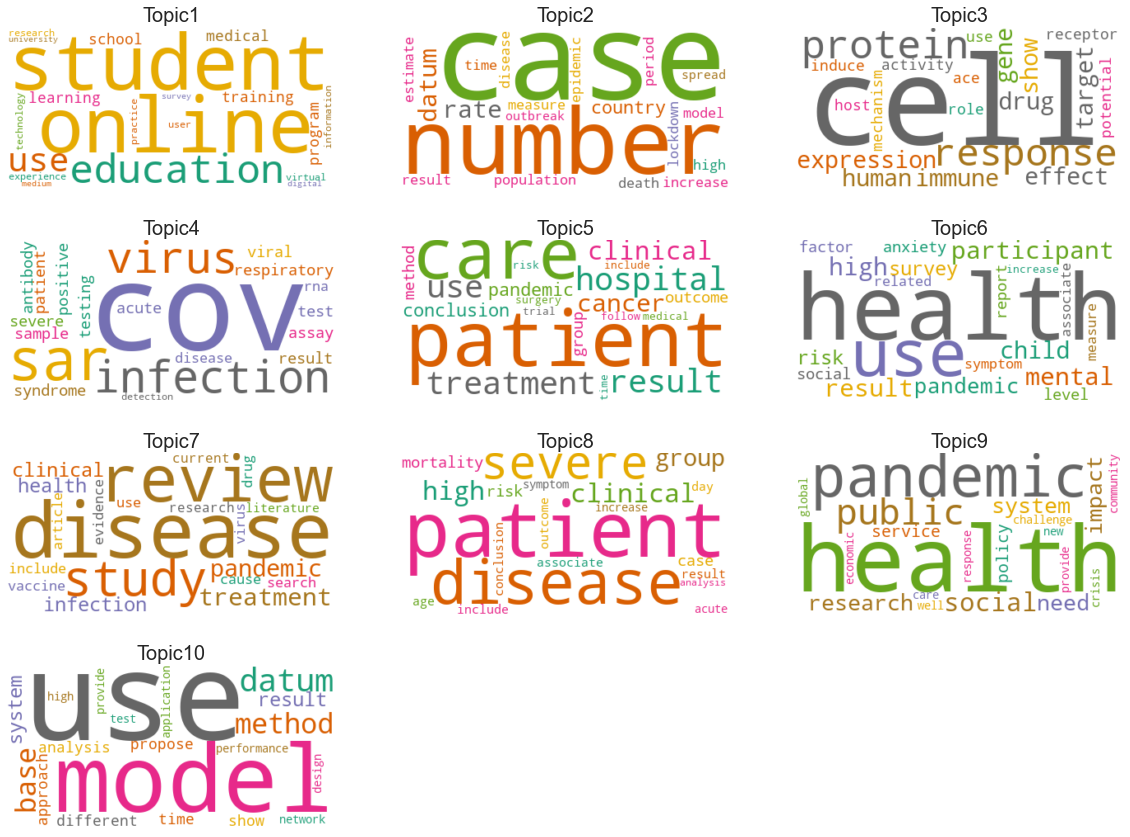

In [96]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(4, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i], size=20)

plt.show()

# Using Topic Coherence Score to Check Model

In [15]:
# Compute Model Perplexity and coherence score
from gensim.models import CoherenceModel

#Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized,
                                    dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5209653039223475


# Visualize Base Model Topic

In [16]:
# import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pyLDAvis

#visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

pyLDAvis.display(LDAvis_prepared)

# Tuning num_topics of LDA model

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
                                                        start=4, limit=30, step=2)

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


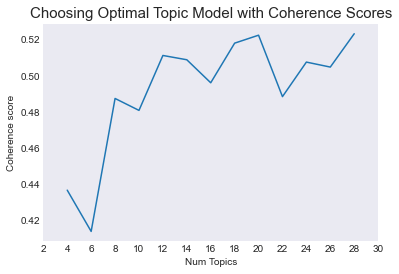

In [32]:
# Show graph
start=4; limit=30; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Choosing Optimal Topic Model with Coherence Scores", size=15)
plt.xticks(np.arange(2,32,step=2))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.savefig("coherence_score.png")

In [25]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
#select the model and print the topics
# model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \
of {coherence_values[best_result_index]}''')

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The 28 topics gives the highest coherence score of 0.5231867390439272


# Final Topic Model

In [26]:
# Final Model
final_model = models.LdaMulticore(corpus=corpus,
                               id2word=id2word,
                               num_topics=28,
                               random_state=100,
                               chunksize=100,
                               passes=10)

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Visualize Topics

In [27]:
#visualize the topics
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(final_model, corpus, id2word)

pyLDAvis.display(p)

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
pyLDAvis.save_html(p, "lda.html")

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
pickle.dump(final_model, open("optimal_lda_model", "wb"))

/Users/crystalhuang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
